# IPL: Mining, Modeling and Predicting

## Dataset source

https://www.kaggle.com/manasgarg/ipl/data

## Goals

- Finding the best lineup and batting order for each team
- Predicting the winner or results of next IPL season
- Deiciding Man-of-the-Match for each match
- Creating a simulation game that simulates matches based on picked team, batting line-up chosen and bowler chosen.

## Mount Drive

You need to download those two csv files and upload them to drive on your end as well.

The below code will ask you for access to your google drive so that it can find those csv files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Imports

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time

## Preprocessing

In [0]:
deliveries_path = "/content/drive/My Drive/deliveries.csv"
matches_path = "/content/drive/My Drive/matches.csv"

deliveries_df = pd.read_csv(deliveries_path)
matches_df = pd.read_csv(matches_path)

In [9]:
deliveries_df.iloc[0:5,] # iloc is a way to index the dataframe by row(s) and column(s) as you can see

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN


In [10]:
deliveries_df.columns # These are the names of the columns you can use to index the df

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [33]:
# Converting datatypes of columns to what they should be
deliveries_df.astype({"batsman_runs":"int32",
                      "over":"int32",
                      "ball":"int32",
                      "bye_runs":"int32",
                      "noball_runs":"int32",
                      "wide_runs":"int32",
                      "penalty_runs":"int32",
                      "legbye_runs":"int32",
                      "extra_runs":"int32",
                      "total_runs":"int32"})

#set(deliveries_df["player_dismissed"])

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150455,636,2,Royal Challengers Bangalore,Sunrisers Hyderabad,20,2,Sachin Baby,CJ Jordan,B Kumar,0,0,0,0,0,0,2,0,2,NaN,NaN,NaN
150456,636,2,Royal Challengers Bangalore,Sunrisers Hyderabad,20,3,Sachin Baby,CJ Jordan,B Kumar,0,0,0,0,0,0,0,0,0,CJ Jordan,run out,NV Ojha
150457,636,2,Royal Challengers Bangalore,Sunrisers Hyderabad,20,4,Iqbal Abdulla,Sachin Baby,B Kumar,0,0,0,1,0,0,0,1,1,NaN,NaN,NaN
150458,636,2,Royal Challengers Bangalore,Sunrisers Hyderabad,20,5,Sachin Baby,Iqbal Abdulla,B Kumar,0,0,0,0,0,0,1,0,1,NaN,NaN,NaN


In [0]:
batsmen_names = set(deliveries_df["batsman"]) # list of all batsmen
batsmen_runs = []
batsmen_singles = []
batsmen_dismissals = []

# Add dummy lists for dots, doubles, fours and sixes

for batter in batsmen_names:
    batter_data = deliveries_df[deliveries_df["batsman"] == batter]
    batsmen_runs.append(sum(batter_data["batsman_runs"]))
    batsmen_dismissals.append(len(deliveries_df[deliveries_df["player_dismissed"] == batter]))
    batsmen_singles.append(len(batter_data[batter_data["batsman_runs"] == 1]))

    # Add way of getting singles, doubles, fours and sixes for each batter

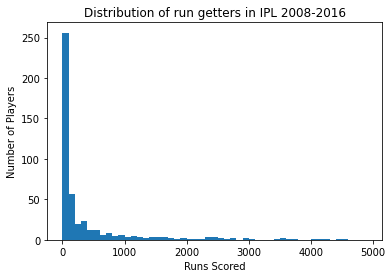

In [35]:
plt.hist(batsmen_runs, bins=np.arange(0,5000,100))
plt.xlabel("Runs Scored")
plt.ylabel("Number of Players")
plt.title("Distribution of run getters in IPL 2008-2016")
plt.show()

In [37]:
batsmen_df = pd.DataFrame(list(zip(batsmen_names, batsmen_runs, batsmen_singles, batsmen_dismissals)), columns=["Name", "Runs", "Singles", "Dismissals"])
batsmen_df.iloc[0:5,]

,Name,Runs,Singles,Dismissals
0,A Symonds,974,288,27
1,P Awana,5,5,2
2,SB Wagh,2,0,2
3,PP Ojha,16,14,12
4,TM Head,205,67,7


In [0]:
high_scorers = batsmen_df.sort_values(by=["Runs"], ascending=False)
high_scorers = high_scorers.iloc[0:50, ] # top 50 run getters only

## Types of Batsmen: Preliminary Analysis

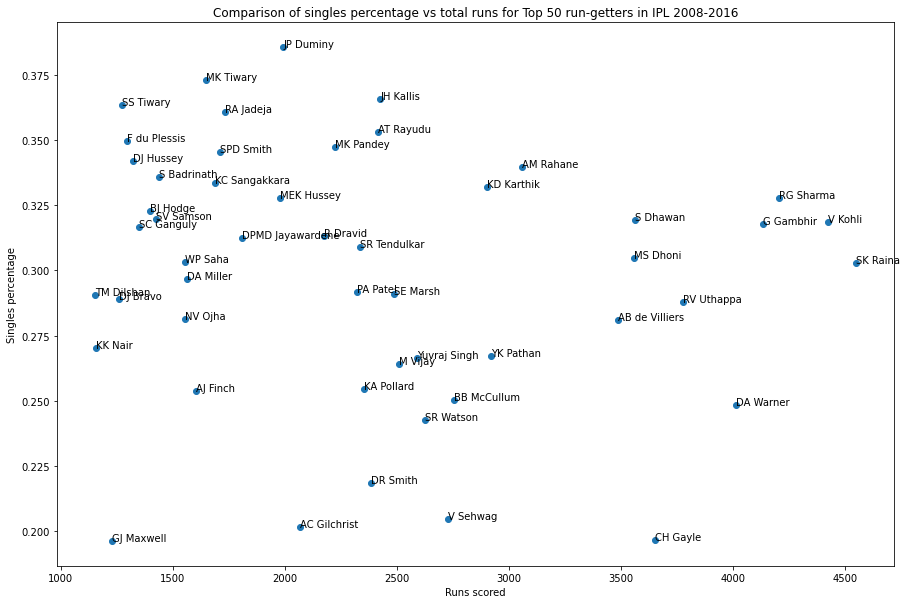

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(high_scorers["Runs"], high_scorers["Singles"] / high_scorers["Runs"])
ax.set_xlabel("Runs scored")
ax.set_ylabel("Singles percentage")
ax.set_title("Comparison of singles percentage vs total runs for Top 50 run-getters in IPL 2008-2016")

for i, batter in enumerate(high_scorers["Name"]):
    ax.annotate(batter, (high_scorers["Runs"].iloc[i], high_scorers["Singles"].iloc[i] / high_scorers["Runs"].iloc[i]))

fig.show()

As expected, Chris Gayle is on the bottom right, Virat Kohli is in the top right, and more traditional batsmen like Sangakarra are in the top left.

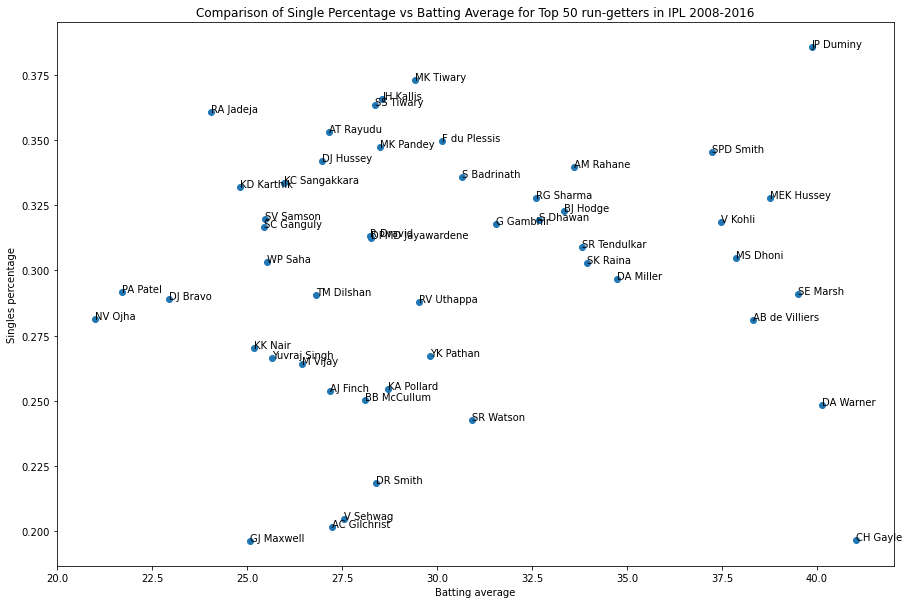

In [45]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(high_scorers["Runs"] / high_scorers["Dismissals"], high_scorers["Singles"] / high_scorers["Runs"])
ax.set_xlabel("Batting average")
ax.set_ylabel("Singles percentage")
ax.set_title("Comparison of Single Percentage vs Batting Average for Top 50 run-getters in IPL 2008-2016")

for i, batter in enumerate(high_scorers["Name"]):
    ax.annotate(batter, (high_scorers["Runs"].iloc[i] / high_scorers["Dismissals"].iloc[i], high_scorers["Singles"].iloc[i] / high_scorers["Runs"].iloc[i]))

fig.show()

This is even more prominent now as Chris Gayle is in the extreme bottom right, and accumulators like Sangakarra, Kallis or even Rayudu are on the top left. Blasters like Maxwell, Sehwag and Gilchrist are also where we expect, hovering closer to bottom left.

### Run Distributions

Once you modify creation of the batsmen dataframe to include 0's, 2's, 4's and 6's, create pie charts for your five favorite players of their run scoring distribution.